# **CIS 6200 Spring 2024 Homework 2**


Objective:
*   Build a suitable vision model
*   Experiment with hyperparameters such as filter size
*   Learn about visualizing layers of vision models

Tasks:

1.  Design a network that can take as input the scrambled images and the final output is an unscrambled original image.

2.  What is the impact of filter sizes on the training loss? Give a plot or table that shows the effect on prediction accuracy of systematically changing the filter size. What size is best? Why?

3. What do you think would work better for this task: ConvNets or ViTs? You don’t have to try out ViTs but based on the readings what arguments do you think would hold for this task.

Optional:
4. Pick two different layers, and show what the layer might be learning using visualization tools such as GradCam. You can read more about GrandCam here: https://github.com/jacobgil/pytorch-grad-cam

**Note: Answers to the questions need to be submitted in the corresponding PDF submission along with this coding submission on gradescope.**

## Required Imports
Feel free to add other libraries you want to use for this homework

In [2]:
import numpy as np
import random
from PIL import Image
from imageio import imsave
from skimage.util.shape import view_as_blocks
import matplotlib.pyplot as plt
import gdown



## Importing the image

In [3]:
url = 'https://drive.google.com/file/d/1b55Zs94Ixu-dPY30A-vIiuTWYQtw93TP/view?usp=drive_link'
gdown.download(url=url, output='image_input_v2.jpg', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1b55Zs94Ixu-dPY30A-vIiuTWYQtw93TP
To: /content/image_input_v2.jpg
100%|██████████| 18.2k/18.2k [00:00<00:00, 10.9MB/s]


'image_input_v2.jpg'

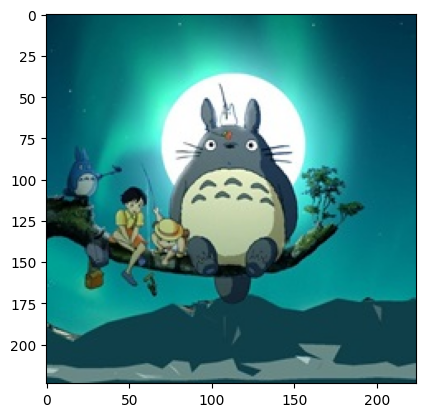

In [4]:
im=np.array(Image.open('/content/image_input_v2.jpg').convert('RGB'))
plt.imshow(im)

## Function to prepare labels

To scramble the image we first cut the image into patches and assign each patch to a label. Since we are only going to deal with a 4x4 scramble, we have 16 labels (0-15) with one for each patch. This function takes in a input image and assigns the same label to each pixel in a patch. You can see the output below for understanding of how the labels are assigned. The output of the function will be a NxN image with the same size of the input image with each value indicating the label of the corresponding pixel.

In [5]:
def label(im, num):
  rows=cols=num
  blk_size=im.shape[0]//rows
  img_lab=np.zeros((im.shape[0], im.shape[1]),dtype=np.uint8)
  for i in range(0,rows):
     for j in range(0,cols):
      x,y = i*blk_size, j*blk_size
      img_lab[x:x+blk_size, y:y+blk_size] = np.full((blk_size, blk_size),i*rows+j)

  return img_lab

In [6]:
print(label(im,4))

[[ 0  0  0 ...  3  3  3]
 [ 0  0  0 ...  3  3  3]
 [ 0  0  0 ...  3  3  3]
 ...
 [12 12 12 ... 15 15 15]
 [12 12 12 ... 15 15 15]
 [12 12 12 ... 15 15 15]]


## Function to shuffle images

From the image and labels we generated we can scramble our image. For each patch of the image we assign a new random label. Then the image patch is moved from its location to the assigned location. You can see the outputs below to see the how the image and labels are scrambled.

In [7]:
def shuffle(im, lb, num, verbose=False):
  map = {}
  rows=cols=num
  blk_size=im.shape[0]//rows

  img_blks=view_as_blocks(im,block_shape=(blk_size,blk_size,3)).reshape((-1,blk_size,blk_size,3))
  lbl_blks=view_as_blocks(lb,block_shape=(blk_size,blk_size)).reshape((-1,blk_size,blk_size))

  img_shuff=np.zeros((im.shape[0],im.shape[1],3),dtype=np.uint8)
  lbl_shuff=np.zeros((lb.shape[0],lb.shape[1]),dtype=np.uint8)

  a=np.arange(rows*rows, dtype=np.uint8)
  b=np.random.permutation(a)

  map = {k:v for k,v in zip(a,b)}
  if(verbose):
    print ("Key Map:-\n" + str(map))

  for i in range(0,rows):
    for j in range(0,cols):
     x,y = i*blk_size, j*blk_size
     img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[map[i*rows + j]]
     lbl_shuff[x:x+blk_size, y:y+blk_size] = lbl_blks[map[i*rows + j]]
  return img_shuff,lbl_shuff

In [8]:
lb = label(im,4)
img,lbl_shuf = shuffle(im,lb,4,True)

Key Map:-
{0: 6, 1: 11, 2: 7, 3: 8, 4: 3, 5: 15, 6: 9, 7: 13, 8: 0, 9: 5, 10: 14, 11: 12, 12: 10, 13: 1, 14: 2, 15: 4}


[[ 6  6  6 ...  8  8  8]
 [ 6  6  6 ...  8  8  8]
 [ 6  6  6 ...  8  8  8]
 ...
 [10 10 10 ...  4  4  4]
 [10 10 10 ...  4  4  4]
 [10 10 10 ...  4  4  4]] 



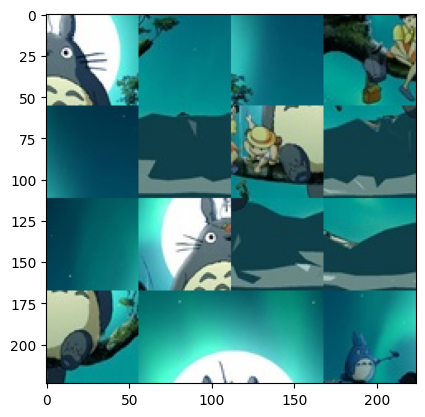

In [9]:
plt.imshow(img)
print(lbl_shuf,'\n')

## Generating the dataset

We can generate the dataset by calling the shuffle function on the same image multiple times. Here we are generating a dataset of 5000 images that are randomly shuffled. Note that for this homework we are trying to overfit the descrambler to the one given image!

In [10]:
images=[]
labels_shuf=[]
labels_rotn=[]

for i in range(0,5000):
 img,lbl_shuf=shuffle(im,lb,4)
 images.append(img)
 labels_shuf.append(lbl_shuf)

imgset=np.array(images)
lblshufset=np.array(labels_shuf)

# Verify the shapes
print (imgset.shape)
print (lblshufset.shape)

# Save the dataset as numpy arrays
np.save("shuffle.npy",imgset)
np.save("slabels.npy",lblshufset)

(5000, 224, 224, 3)
(5000, 224, 224)


You need to design a network that can take as input the scrambled images and the final output is an unscrambled original image.

What will the model output? Here are a few ways to think of this:


*  An end-to-end architecture that gives as output the unscrambled original image.
*  A discretization such as the shuffling label for each patch of image_size//4.
* A pixel level prediction of the target location to unscramble.

Once you have the output from the model, think about how you can process it to output the unshuffled image.

Here are two directions you might want to think of with respect to selecting the model:
* Pre-trained huggingface vision model and fine-tuning it.
* Build a model from scratch in pytorch.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [17]:
class PatchedImageDataset(Dataset):
    def __init__(self):
        self.data = np.load('shuffle.npy')
        self.labels = np.load('slabels.npy')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # Splitting the image into 4x4 patches
        patches = image.reshape(4, 56, 4, 56, 3).swapaxes(1, 2).reshape(-1, 56, 56, 3)
        patch_labels = label.reshape(4, 56, 4, 56).swapaxes(1, 2).reshape(-1, 56, 56)
        patch_labels = patch_labels[:, 0, 0]  # Taking one label per patch

        return torch.tensor(patches, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(patch_labels, dtype=torch.long)

class PatchOrderCNN(nn.Module):
    def __init__(self):
        super(PatchOrderCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 16)  # Output: 16 positions for each patch
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.maxpool(self.relu(self.conv3(x)))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [18]:
dataset = PatchedImageDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = PatchOrderCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for patches, patch_labels in dataloader:
        optimizer.zero_grad()
        # Each batch contains batches of patches
        for i in range(patches.shape[1]):
            patch = patches[:, i, :, :, :]
            label = patch_labels[:, i]

            outputs = model(patch)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')


Epoch 1, Loss: 4.30252370628348
Epoch 2, Loss: 3.537591215573196e-05
Epoch 3, Loss: 5.741019519759849e-06
Epoch 4, Loss: 1.176621883279947e-06
Epoch 5, Loss: 2.803933204587121e-07
Epoch 6, Loss: 3.7751187587158e-08
Epoch 7, Loss: 3.096499039344552e-08
Epoch 8, Loss: 1.580282272202038e-08
Epoch 9, Loss: 5.45743129385407e-10
Epoch 10, Loss: 0.0


In [23]:
def unscramble_image(model, scrambled_image):
    # Assuming scrambled_image is a numpy array of shape [224, 224, 3]

    # Convert the image to PyTorch tensor and normalize if necessary
    scrambled_image = torch.tensor(scrambled_image, dtype=torch.float32).permute(2, 0, 1)  # Shape [3, 224, 224]

    # Split the image into patches
    patches = scrambled_image.unfold(1, 56, 56).unfold(2, 56, 56)  # Shape [3, 4, 4, 56, 56]
    patches = patches.contiguous().view(3, -1, 56, 56).permute(1, 0, 2, 3)  # Reshape to [16, 3, 56, 56]

    # Predict the position for each patch
    model.eval()
    with torch.no_grad():
        outputs = model(patches)
        _, predicted_positions = torch.max(outputs, 1)

    # Reassemble the image based on predicted positions
    unscrambled_image = np.zeros((224, 224, 3), dtype=np.uint8)
    for idx, position in enumerate(predicted_positions):
        row = position // 4  # Assuming 4x4 grid
        col = position % 4
        patch = patches[idx].permute(1, 2, 0).numpy()
        unscrambled_image[row*56:(row+1)*56, col*56:(col+1)*56, :] = patch

    return unscrambled_image




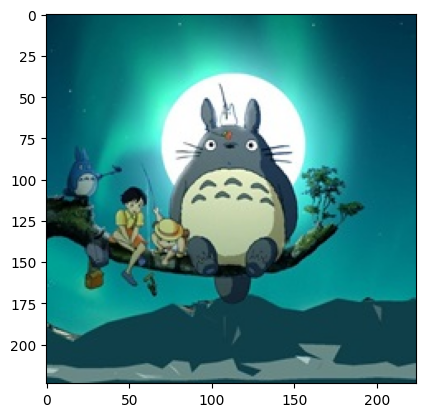

In [32]:
# Example usage:
model = model  # Load your model
scrambled_image = imgset[100]  # Load your scrambled image
unscrambled = unscramble_image(model, scrambled_image)
unscrambled_image = Image.fromarray(unscrambled)
unscrambled_image.show()
plt.imshow(unscrambled_image)